In [1070]:
import sys
import os
import glob
from skimage import io
from matplotlib import pyplot as plt
from skimage.transform import resize, rotate
from skimage.measure import find_contours, approximate_polygon, regionprops, label
from skimage.color import label2rgb
from skimage.draw import circle_perimeter, rectangle_perimeter, circle, line
from skimage.util import invert
from skimage import color
from skimage.morphology import closing, opening, disk, erosion, dilation
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny
import math 
import numpy as np
from matplotlib import cm
from skimage.feature import corner_harris, corner_subpix, corner_peaks

In [1148]:
# do wersji v1
def get_line_length(point1, point2):
    return math.pow((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 , 0.5)
def get_angle_of_line(line):
    (point1, point2) = line
    return math.atan2(point2[1] - point1[1], point2[0] - point1[0]) * 180 / np.pi

def get_angle_to_rotate_image(image):
    thresh = threshold_otsu(image)
    image = image > thresh
    edges = canny(image, sigma=1, low_threshold=False, high_threshold=True)
    min_length = image.shape[0] if image.shape[0] >= image.shape[1] else image.shape[1]
    lines = probabilistic_hough_line(edges, threshold=10, line_length=int(min_length/2),
                                     line_gap=10)

    longest_line = (lines[0],  get_line_lenght(lines[0][0], lines[0][1]))
    for line in lines:
        temp_lenght = get_line_lenght(line[0], line[1])
        if temp_lenght > longest_line[1]:
            longest_line = (line, temp_lenght)
    
    angle = get_angle_of_line(longest_line[0])
    print(longest_line[0])
    return angle

In [791]:
# do wersji v2 - nieużywane na razie
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny


def compare_2_numbers_with_range(n1, n2, range=3):
    difference = abs(n1-n2)
    return difference <= range
compare_2_numbers_with_range(5.40, 3.10, 3)

def compare_2_points_with_range(point1, point2, range=3):
    x1, y1 = point1
    x2, y2 = point2
    return compare_2_numbers_with_range(x1, x2, range) and compare_2_numbers_with_range(y1, y2, range)
compare_2_points_with_range((10,20), (8,27), 5)

def check_if_perpendicular_lines(line1, line2):
    point11, point12 = line1
    point21, point22 = line2
    if compare_2_points_with_range(point11, point21, 10) or compare_2_points_with_range(point11, point22, 10) or compare_2_points_with_range(point12, point21, 10):     
        angle_between_lines = abs(get_angle_of_line(line1)-get_angle_of_line(line2))
#         print("line1: ", line1)
#         print("line2: ", line2)
#         print("get_angle_of_line(line1): ", get_angle_of_line(line1))
#         print("get_angle_of_line(line2): ", get_angle_of_line(line2))
#         print("angle_between_lines: ", angle_between_lines)
        if compare_2_numbers_with_range(angle_between_lines, 90, 10) or compare_2_numbers_with_range(angle_between_lines, 270, 10):
            return True
    
    return False

def check_if_parallel_lines(line1, line2):
    point11, point12 = line1
    point21, point22 = line2
    if compare_2_points_with_range(point11, point21, 10) or compare_2_points_with_range(point11, point22, 10) or compare_2_points_with_range(point12, point21, 10):     
        angle_between_lines = abs(get_angle_of_line(line1)-get_angle_of_line(line2))
        print(angle_between_lines)
        if compare_2_numbers_with_range(angle_between_lines, 0, 10) or compare_2_numbers_with_range(angle_between_lines, 360, 10):
            return True
    
    return False

def get_base_line(image):
    thresh = threshold_otsu(image)
    image = image > thresh
    edges = canny(image, sigma=1, low_threshold=False, high_threshold=True)
    min_length = image.shape[0] if image.shape[0] >= image.shape[1] else image.shape[1]
    lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                     line_gap=10)
    possible_baselines = list()
    for line1 in lines:
        counter = 0
        for line2 in lines:
#             if check_if_parallel_lines(line1, line2):
#                 continue
            if check_if_perpendicular_lines(line1, line2):
                counter += 1
        if counter >= 2:
            possible_baselines.append(line1)
            
    if len(possible_baselines) == 0:
        return None

    longest_line = possible_baselines[0]
    longest_distance = get_line_lenght(possible_baselines[0][0],possible_baselines[0][1])
    for line in possible_baselines[1:]:
        temp = get_line_lenght(line[0], line[1])
        if temp > longest_distance:
            longest_distance = temp
            longest_line = line
    
    return longest_line



In [1163]:
# do wersji v3 - szukanie punktów skrajnych
def get_extreme_points(image):
    possible_baseline_points = corner_peaks(corner_harris(image), min_distance=1)
    minHeight = image.shape[0]-1
    maxHeight = 0 
    minWidth = image.shape[1]-1 
    maxWidth = 0 
    for height, width in possible_baseline_points:
        if height <= minHeight:
            minHeight = height
        if width <= minWidth:
            minWidth = width
            
        if height >= maxHeight:
            maxHeight = height
        if width >= maxWidth:
            maxWidth = width
            
    extreme_points = set()
    image = color.grey2rgb(image)
    for height, width in detected_points:  
        if height == minHeight or height == maxHeight or width == minWidth or width == maxWidth:
            rr, cc = circle_perimeter(int(height),int(width), 3)
            image[rr, cc] = [255,0,0]
            extreme_points.add((height, width))
        
    return image, extreme_points

# image = io.imread(images_paths[5])
# io.imshow(image[50-10:50+10,5-10:5+10])
# image, p = get_extreme_points(image) 
# print(p)
# io.imshow(image)

def clamp(n, smallest, largest): 
    return max(smallest, min(n, largest))
# def check_if_it_is_right_angle(image, point, radius=10):
#     (height, width) = point
#     height = int(height)
#     width = int(width)
#     (image_height, image_width) = image.shape
    
#     right_width_min = clamp(width-radius-1, 0, image_width)
#     right_width_max = clamp(width+radius+1, 0, image_width)
#     right_height_min = clamp(height-radius-1, 0, image_height)
#     right_height_max = clamp(height+radius+1, 0, image_height)
#     print(right_width_min, right_width_max, right_height_min, right_height_max)
#     slice_of_image = image[right_height_min:right_height_max, right_width_min:right_width_max]
    
# #     thresh = threshold_otsu(slice_of_image)
#     thresh = 127
#     slice_of_image = slice_of_image > thresh
    
#     labeled = label(slice_of_image)
#     print(point)
#     print(len(labeled))
#     props = regionprops(labeled)
#     white_area = props[0].area
#     black_area = (radius*2+1)**2-white_area
    
#     white_to_black_ratio = white_area/(white_area+black_area)

#     print(white_area)
#     print(black_area)
#     print(white_to_black_ratio)
#     print("=========================")
#     return True if compare_2_numbers_with_range(0.25, white_to_black_ratio, 0.03) else False

def check_if_it_is_right_angle_using_angles_of_lines(image, point, radius=10):
    (height, width) = point
    height = int(height)
    width = int(width)
    (image_height, image_width) = image.shape
    
#     image = color.gray2rgb(image)
#     image[height, width] = (255,0,0)
    point_height_in_sliced_image = radius+1
    point_width_in_sliced_image = radius+1
    if height-radius < 0 :
        point_height_in_sliced_image = radius - (radius-height)
    if width-radius < 0:
        point_width_in_sliced_image = radius - (radius-width)
    middle_point = (point_height_in_sliced_image, point_width_in_sliced_image)
#     print("nowe")
#     print(point_height_in_sliced_image)
#     print(point_width_in_sliced_image)
    right_width_min = clamp(width-radius-1, 0, image_width)
    right_width_max = clamp(width+radius+1, 0, image_width)
    right_height_min = clamp(height-radius-1, 0, image_height)
    right_height_max = clamp(height+radius+1, 0, image_height)
#     print(right_width_min, right_width_max, right_height_min, right_height_max)
    slice_of_image = image[right_height_min:right_height_max, right_width_min:right_width_max]
    
    
    edges = canny(slice_of_image)
    positions_of_whites = np.where(edges==True)
    positions_of_whites = list(zip(positions_of_whites[0],positions_of_whites[1]))
    
    
    #zbiory kątów
#     print("middle_point: ", middle_point)
    list_of_angles = list()
    for white_point in positions_of_whites:
        add = True
        if get_line_length(middle_point, white_point) > radius/5:
            point_angle = get_angle_of_line((middle_point, white_point))
#             print("white_point: ",white_point)
#             print("point_angle: ",point_angle)
            for angle in list_of_angles:
                if compare_2_numbers_with_range(point_angle, angle, 20):
#                     print("point_angle: ", point_angle)
#                     print("angle: ", angle)
                    add = False
            if add:
#                 print("point_angle: ", point_angle)
#                 print("white_point: ", white_point)
                list_of_angles.append(point_angle)
#     print("list_of_angles PRZED")
#     print(list_of_angles)
    exists_90 = False
    exists_180 = False
    new_list_of_angles = list()
    for angle in list_of_angles:
        if compare_2_numbers_with_range(90, abs(angle), 10):
            if exists_90 == False:
                exists_90 = True
                new_list_of_angles.append(angle)
        elif compare_2_numbers_with_range(180, abs(angle), 10):
            if exists_180 == False:
                exists_180 = True
                new_list_of_angles.append(angle)
        else:
            new_list_of_angles.append(angle)
        
    list_of_angles = new_list_of_angles
        
#     print("list_of_angles PO")
#     print(list_of_angles)

    if len(list_of_angles) == 2:
        n_of_pixels = 3
        first_point = None
        first_point_angle = None
        first_list_points_in_one_line = list()
        for white_point in positions_of_whites:
            if get_line_length(middle_point, white_point) > radius/2:
                angle_of_line = get_angle_of_line((middle_point, white_point))
                if compare_2_numbers_with_range(angle_of_line, list_of_angles[0], 10):
                    first_list_points_in_one_line.append(white_point)


        second_list_points_in_one_line = list()

        for white_point in positions_of_whites:
            if get_line_length(middle_point, white_point) > radius/2:
                angle_of_line = get_angle_of_line((middle_point, white_point))
                if compare_2_numbers_with_range(angle_of_line, list_of_angles[1], 20):
                    second_list_points_in_one_line.append(white_point)
                    
        if len(first_list_points_in_one_line) >= n_of_pixels and len(second_list_points_in_one_line) >= n_of_pixels:               
            if check_if_perpendicular_lines((middle_point,first_list_points_in_one_line[0]),(middle_point,second_list_points_in_one_line[0])):
                return True
    else:
        return False
    
#     print("middle_point: ", middle_point)
#     print("f_point: ", first_list_points_in_one_line)
#     print("s_point: ", second_list_points_in_one_line)




def get_points_with_right_angle_using_angles_of_lines(image):
    possible_baseline_points = corner_peaks(corner_harris(image), min_distance=1)
    points_with_right_angle = set()
    for c in possible_baseline_points:
        if check_if_it_is_right_angle_using_angles_of_lines(image=image, point=(c[0],c[1]), radius=30):
            points_with_right_angle.add((c[0],c[1]))
    
    return points_with_right_angle

def check_if_it_is_right_angle_using_areas_of_neighborhood(image, point, radius=5):
    (height, width) = point
    height = int(height)
    width = int(width)
    (image_height, image_width) = image.shape
    
    right_width_min = clamp(width-radius-1, 0, image_width)
    right_width_max = clamp(width+radius+1, 0, image_width)
    right_height_min = clamp(height-radius-1, 0, image_height)
    right_height_max = clamp(height+radius+1, 0, image_height)
#     print(right_width_min, right_width_max, right_height_min, right_height_max)
    slice_of_image = image[right_height_min:right_height_max, right_width_min:right_width_max]
    
#     thresh = threshold_otsu(slice_of_image)
    thresh = 127
    slice_of_image = slice_of_image > thresh
    
    labeled = label(slice_of_image)

    props = regionprops(labeled)
    white_area = props[0].area
    black_area = (radius*2+1)**2-white_area
    
    white_to_black_ratio = white_area/(white_area+black_area)
#     print("ratio: ", white_to_black_ratio)
#     print("white: ", white_area)
#     print("black: ", black_area)
#     return slice_of_image
    return True if compare_2_numbers_with_range(0.27, white_to_black_ratio, 0.03) else False


def get_points_with_right_angle_using_areas_of_neighborhood(image):
    possible_baseline_points = corner_peaks(corner_harris(image), min_distance=1)
    points_with_right_angle = set()
    for c in possible_baseline_points:
        if check_if_it_is_right_angle_using_areas_of_neighborhood(image=image, point=(c[0],c[1]), radius=30):
            points_with_right_angle.add((c[0],c[1]))
    
    return points_with_right_angle


# img = io.imread(images_paths[9])
# img2 = check_if_it_is_right_angle_using_angles_of_lines(img, (82.8913043478261, 42.0), radius=30)
# img2 = color.gray2rgb(img2)
# # img2[34,60] = (255,0,0)
# img2[31,31] = (255,0,0)
# io.imshow((img2))


# dla set1: źle 13 i 17, bo krzywo wykrywa kąty wielokąta

list_of_angles PO
[121.26373169437743, 9.462322208025617]
121.26373169437743
120.37912601136834
121.60750224624891
120.65066795705286
122.0053832080835
120.96375653207352
119.98163936884934
122.47119229084849
121.32869286780416
120.25643716352927
121.75948008481282
120.57922687248902
122.27564431457763
120.96375653207352
122.90524292298792
121.42956561483851
123.69006752597979
122.0053832080835
120.46554491945989
124.69515353123398
122.73522627210761
120.96375653207352
121.60750224624891
23.19859051364819
21.80140948635181
25.016893478100023
23.62937773065682
25.201123645475075
23.962488974578186
25.346175941946694
24.22774531795417
26.56505117707799
25.463345061871614
24.443954780416536
26.56505117707799
25.559965171823812
24.623564786163612
26.56505117707799
25.641005824305285
26.56505117707799
25.709953780811265
26.56505117707799
25.769327624338718
middle_point:  (31, 10)
f_point:  [(14, 38), (14, 39), (15, 36), (15, 37), (16, 34), (16, 35), (16, 36), (17, 32), (17, 33), (17, 34), (

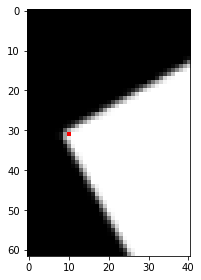

In [1123]:
img = io.imread(images_paths[18])
img2 = check_if_it_is_right_angle_using_angles_of_lines(img, (98, 10), radius=30)
img2 = color.gray2rgb(img2)
# img2[32,23] = (255,0,0)
# img2[12,31] = (255,0,0)
img2[31,10] = (255,0,0)
io.imshow((img2))

In [1086]:
check_if_perpendicular_lines(((31,31),(3, 30)), ((31,31), (13,31)))

False

In [1041]:
from skimage.segmentation import clear_border
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
def clear_images(images):
    images_cleared = list()
    for img in images:
        thresh = threshold_otsu(img)
        bw = closing(img > thresh, square(3))
        cleared = clear_border(bw)
        images_cleared.append(cleared)
    return images_cleared

def clear_image(image):
    thresh = threshold_otsu(img)
    bw = closing(img > thresh, square(3))
    cleared = clear_border(bw)
    return cleared

def rotate_images(images):
    images_rotated = list()
    for img in images:
        angle = get_angle_to_rotate_image(img)
        img = rotate(img, angle).astype(np.uint8)
        images_rotated.append(img)
    return images_rotated

def resize_images(images):  
    max_height, max_width = images[0].shape
    for image in images:
        if image.shape[0] > max_height:
            max_height = image.shape[0]
        if image.shape[1] > max_width:
            max_width = image.shape[1]
#     shape = (longest_height, longest_width)
#     images_resized = [(resize(img, shape)*255).astype(np.uint8) for img in images]
    
    images_resized = list()
    for image in images:
        scale = max_width/image.shape[1]
        new_shape = (int(image.shape[0]*scale), int(image.shape[1]*scale))
        resized_image = (resize(image, new_shape)*255).astype(np.uint8)
        images_resized.append(resized_image)
    
    return images_resized

def cut_images_sides(images):
    images_rect = list()
    images_cut = list()
    for img in images:
#         thresh = threshold_otsu(img)
#         bw = closing(img > thresh, square(3))
#         img = clear_border(bw)
        
        label_img, num = label(img, connectivity=2, return_num=True, background=0)
        region_props = regionprops(label_img)
#         print(num)
#         print(region_props[0].bbox)
        biggest_region = region_props[0]
        for region in region_props:
            if region.area > biggest_region.area:
                biggest_region = region

#         x,y = rectangle_perimeter((1,biggest_region.bbox[1]), (img.shape[0]-2,biggest_region.bbox[3]))
#         x,y = rectangle_perimeter((biggest_region.bbox[0], biggest_region.bbox[1]), (biggest_region.bbox[2], biggest_region.bbox[3]))
#         img = color.grey2rgb(img)
#         img[x,y] = [255,0,0]
#         images_rect.append(img)
#         images_cut.append(img[:,biggest_region.bbox[1]:biggest_region.bbox[3]+1])
        images_cut.append(img[biggest_region.bbox[0]:biggest_region.bbox[2],biggest_region.bbox[1]:biggest_region.bbox[3]+1])

        
    return images_cut

In [1156]:
# wersja używa najdłuższej linii w figurze jako podstawy, nie zawsze będzie działało dla późniejszych przykałdów
def rotate_scale_and_cut_v1(images_paths):
    images = [io.imread(path) for path in images_paths]
    images = rotate_images(images)
    images = cut_images_sides(images)
    images = resize_images(images)
    images = [img*255 for img in images]
    images = [opening(closing(img, disk(9)), disk(9)) for img in images]
#     for img in images:
#         labeled = label(invert(img))
#         props = regionprops(labeled)
#         print(len(props))
#     images = [invert(img) for img in images]   
    return images

# wersja szuka linii, które mają kąt prosty jako podstawa, działa słabiej
def rotate_scale_and_cut_v2(images_paths):
    images_new = list()
    images = [io.imread(path) for path in images_paths]
    for i, image in enumerate(images):
        base_line = get_base_line(image)
        if base_line == None:
            images_new.append(image)
            print('Nie znaleziono podstawy dla obrazka numer (indeks w tablicy): ', i )
            continue
        print(i, base_line)
        angle = get_angle_of_line(base_line)
        img = rotate(image, angle)
        images_new.append(img)
        
    images_new = cut_images_sides(images_new)
    images_new = resize_images(images_new)
    images_new = [opening(closing(img, disk(9)), disk(9)) for img in images_new]
    return images_new

def rotate_scale_and_cut_v3(images_paths):
    images_new = list()
    images = [io.imread(path) for path in images_paths]
    for i, image in enumerate(images):
        points2 = get_points_with_right_angle_using_areas_of_neighborhood(image)
        points1 = get_points_with_right_angle_using_angles_of_lines(image)
        baseline = list(points1.intersection(points2))
#         print("============{0}=============".format(i))
#         print(points1)
#         print(points2)
#         print(baseline)
        
        if len(baseline) != 2:
            baseline = None
        if baseline == None:
            images_new.append(image)
            print('Nie znaleziono podstawy dla obrazka numer (indeks w tablicy): ', i )
            continue
#         baseline = (baseline[1],baseline[0])
        print(i, baseline)
        baseline = [(el[1],el[0]) for el in baseline]
        angle = get_angle_of_line(baseline)
        img = rotate(image, angle)
        images_new.append(img)

    images_new = cut_images_sides(images_new)
    images_new = resize_images(images_new)
    images_new = [opening(closing(img, disk(9)), disk(9)) for img in images_new]
    return images_new

# def rotate_and_scale_v3(images_paths):
#     images_changed = list()
#     images = [io.imread(path) for path in images_paths]
#     for image in images:
        
# #     images_new = cut_images_sides(images_new)
# #     images_new = resize_images(images_new)
# #     images_new = [opening(closing(img, disk(9)), disk(9)) for img in images_new]
#     return images_changed

0 [(183, 6), (187, 253)]
1 [(9, 287), (365, 9)]
2 [(196, 247), (5, 142)]
3 [(390, 10), (362, 295)]
Nie znaleziono podstawy dla obrazka numer (indeks w tablicy):  4
Nie znaleziono podstawy dla obrazka numer (indeks w tablicy):  5
6 [(237, 10), (433, 206)]
7 [(181, 218), (5, 187)]
8 [(90, 6), (6, 152)]
9 [(7, 122), (142, 365)]
10 [(115, 239), (135, 13)]
Nie znaleziono podstawy dla obrazka numer (indeks w tablicy):  11
12 [(61, 6), (318, 120)]
13 [(527, 7), (7, 7)]
14 [(181, 11), (455, 416)]
15 [(4, 64), (145, 4)]
16 [(333, 384), (7, 211)]
Nie znaleziono podstawy dla obrazka numer (indeks w tablicy):  17
18 [(6, 204), (271, 204)]
19 [(486, 494), (9, 329)]
20 [(359, 253), (37, 293)]
21 [(8, 164), (207, 157)]
22 [(311, 187), (103, 298)]
23 [(8, 139), (104, 335)]
Nie znaleziono podstawy dla obrazka numer (indeks w tablicy):  24
25 [(6, 137), (187, 6)]
26 [(51, 300), (380, 236)]
27 [(8, 97), (114, 92)]
28 [(123, 9), (9, 464)]
Nie znaleziono podstawy dla obrazka numer (indeks w tablicy):  29
3

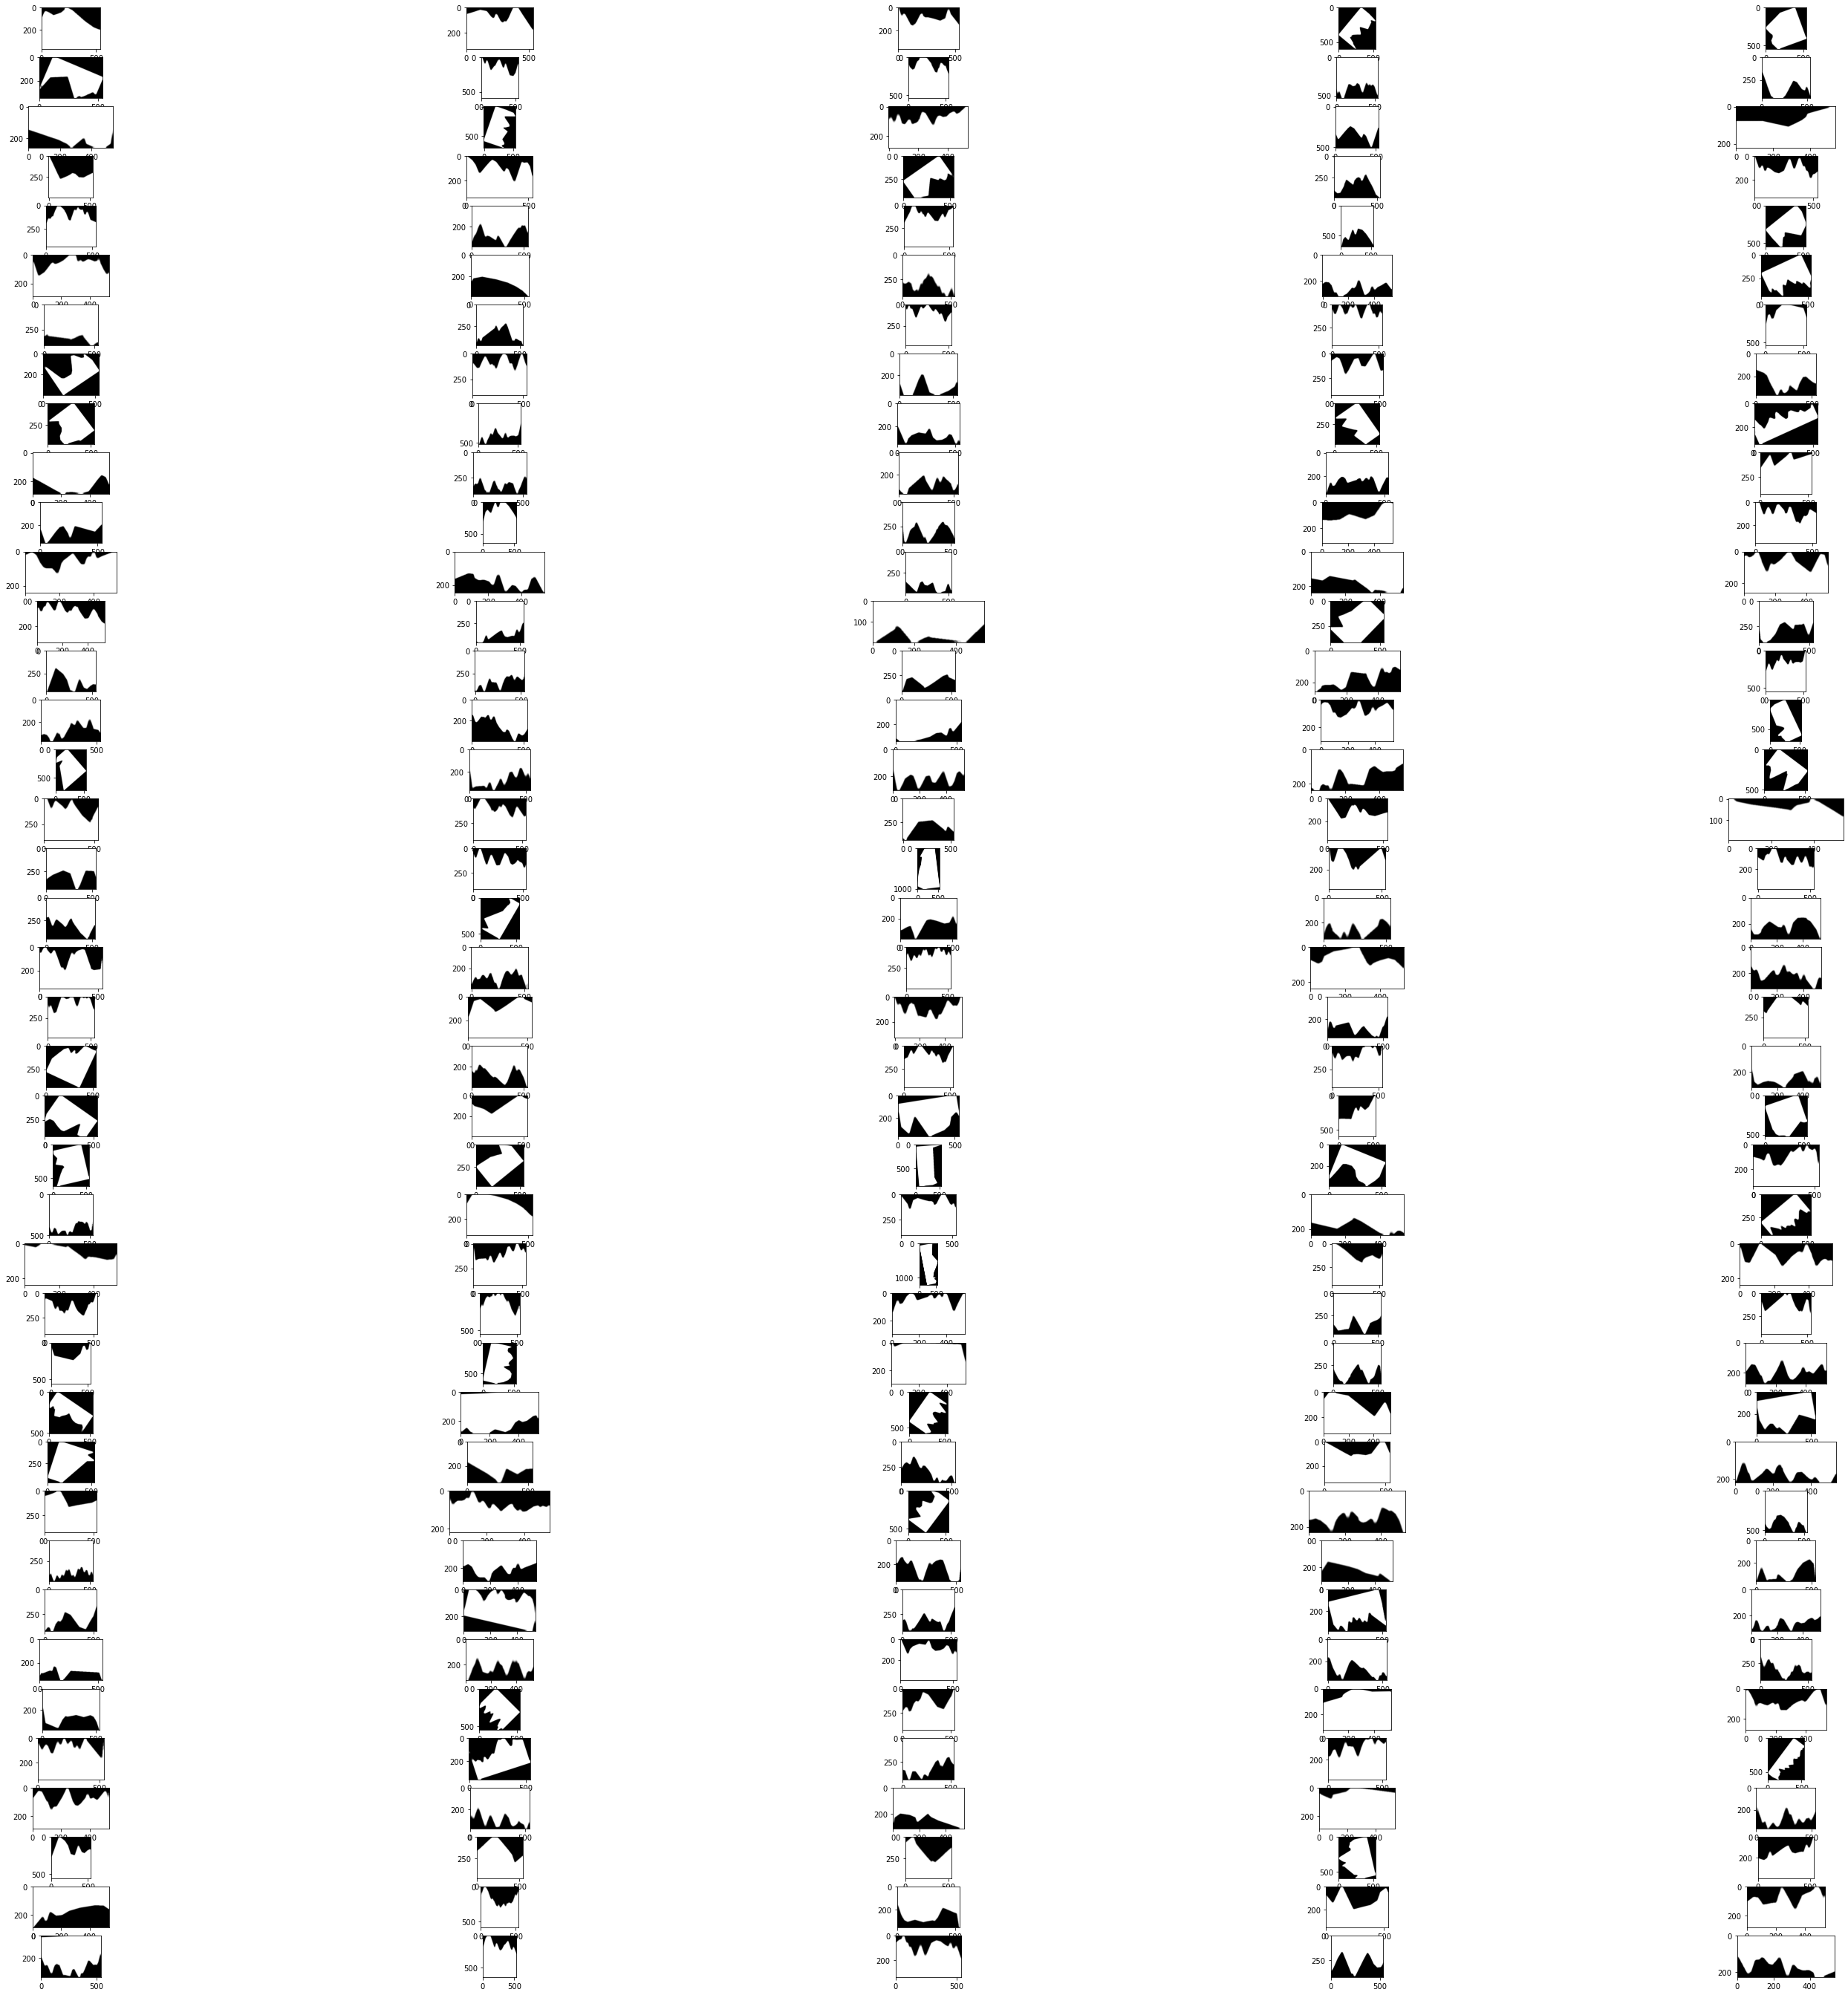

In [1165]:
n_of_cases = 5
path = os.path.join('D:\Dokumenty\Projekty\PIRO/project1/proj1_daneA\set6', '')
images_paths = glob.glob(os.path.join(path, '*.png'))

images = rotate_scale_and_cut_v3(images_paths)
fig = plt.figure(figsize=(50,50))
columns = 5
rows = (len(images_paths)/columns)+1
for i, img in enumerate(images):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap=plt.cm.gray)


(193, 294)


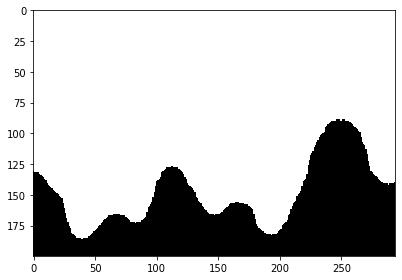

In [7]:
print(images[5].shape)
io.imshow(images[12])

(200, 294)


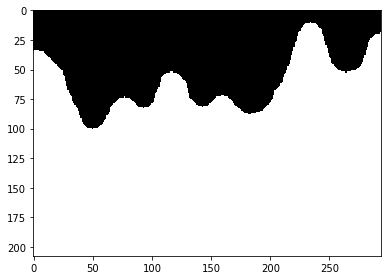

In [8]:
print(images[10].shape)
io.imshow(images[7])

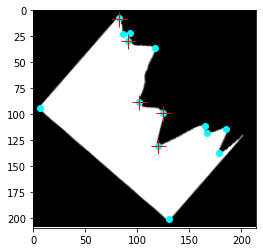

In [1142]:
# przykład znajdowania punktów (kątów w sumie nwm)

image = io.imread(images_paths[0])
coords = corner_peaks(corner_harris(image), min_distance=1)
# print(coords)
coords_subpix = corner_subpix(image, coords, window_size=13)
# print(coords_subpix)

fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
ax.axis((0, image.shape[1], image.shape[0], 0))
plt.show()


# contours = find_contours(image, level=10)
# image = color.grey2rgb(image)
# print(len(contours))
# print(image.shape)
# for n, contour in enumerate(contours):
#     appr_pol = approximate_polygon(contour, tolerance=5)
#     print(appr_pol)
#     for c in appr_pol:
#         print(c[0], c[1])
#         x,y = circle(int(c[0]),int(c[1]), 2)
#         image[x,y] = [255,0,0]
        
# io.imshow(image)

In [1152]:
get_angle_of_line(((6,94),(130,201)))

40.79101507582978

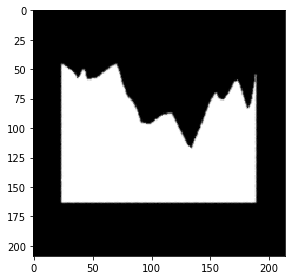

In [1153]:
io.imshow(rotate(image, 41))